<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/basics/data-loading-pipeline.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/basics/data-loading-pipeline.ipynb)

# Data Loading

Handling data consumes 90% of the active work time in many machine learning projects.

SpeechBrain complements standard PyTorch data loading in handling variable-length sequences, large datasets, and complex data transformation pipelines. These are typical challenges when working with speech, but SpeechBrain tries not to make assumptions about your data.

## Install dependencies


In [71]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'speechllm_librispeech'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

In [72]:
import speechbrain
import torch

In this tutorial we will use MiniLibriSpeech from https://www.openslr.org/resources/31: we download the validation set in the following two cells as well as images and scripts.

In [73]:
%%capture
# downloading mini_librispeech dev data
!wget https://www.openslr.org/resources/31/dev-clean-2.tar.gz
!tar -xvzf dev-clean-2.tar.gz

## Preface: PyTorch data loading pipeline

SpeechBrain data-IO follows and extends [PyTorch data loading](https://pytorch.org/docs/stable/data.html). This preface section recaps PyTorch data loading and does not yet consider the SpeechBrain data loading extensions.

### Overview
PyTorch data loading can run in many configurations,
but a typical approach has these basic elements:
- a [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), which loads data points one-at-a-time.
- a [collation function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn), or ``collate_fn`` for short, which takes a list of data points and forms a batch.
- a [Sampler](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler), which determines the order in which the Dataset is iterated.
- a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which combines the elements above (and has defaults for ``collate_fn`` and Sampler), and orchestrates the whole pipeline.



### Dataset
The role of the Dataset is to produce single data points. Typically they are loaded off the disk, but they could also come from some more complex source or in some cases just from RAM. You can write your own Dataset subclass or sometimes you can use a standardized class. The training, validation, and test subsets get their own Dataset instances.

The Dataset interface is simple; it implements
`__getitem__` and usually also `__len__`. Usually, "map-style" Datasets are used, but it's worth noting that PyTorch also has a notion of [IterableDataset](https://pytorch.org/docs/stable/data.html#iterable-style-datasets)s.

`__getitem__` can return _anything_ because data can look like _anything_. Often, though, a data point consists of multiple associated things (e.g. an image and a label, or a speech waveform and its transcription). The Dataset should return all of these associated things.

It is also relatively common for the Dataset to somehow transform the data on the fly, on the CPU.


### Collation function

The ``collate_fn`` just converts a list of examples into a PyTorch tensor batch. If the data has variable-length sequences, ``collate_fn`` usually needs to implement padding.

### Sampler
Typically users don't need to create their own sampler; the two default options are to iterate in the original Dataset order or to iterate in random order.


### DataLoader

The DataLoader takes the other elements above and many other arguments such as batch size. The DataLoader has basic defaults for all arguments (except the Dataset, of course), but it's worthwhile to understand the [args](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The DataLoader object is iterated in the training loop, and every Dataset instance (e.g. training, validation, test) gets its own DataLoader.
```python
train_loader = DataLoader(train_data, collate_fn=PaddedBatch, batch_size=32, num_workers=2)
for batch in train_loader:
    pred = model(batch.signal)
    ...
```

The iterator that DataLoader returns can either load batches in the same process that it is created in (`num_workers=0`), or it can start a new process (`num_workers=1`) or multiple new processes (`num_workers>1`). Because of the Global Interpreter Lock, Python cannot work on two tasks at the same time in a single process. Using at least one background worker process to load data while simultaneously running training is often essential for taking full advantage of GPU compute resources.

## SpeechBrain Basic dataIO

The basic dataIO pipeline is organized around three "key" blocks: **DynamicItemDataset**, **Dynamic Items Pipelines (DIPs)**  and **CategoricalEncoder** which are tightly connected.

**DynamicItemDataset** inherits from `torch.utils.data.Dataset` and has been built to work together with **Dynamic Items Pipelines** to provide a straightforward and flexible way to fetch and transform data and labels from the raw dataset stored in your disk.

**DIPs** consists of user-defined functions in which the user specifies operations applied to metadata and data contained in the dataset. E.g. reading and augmenting an audio file or encoding a sequence of words using SentencePiece tokenizer.
These functions are called inside **DynamicItemDataset** `__getitem__` method and are run in parallel on the CPU.

The **CategoricalEncoder** is a convenient abstraction we provide for multi-class classification problems and it is sub-classed into **TextEncoder** and **CTCTextEncoder** which instead can be used for sequence-to-sequence applications related to text, such as ASR.


Thanks to these abstractions, most of the work necessary to set up the data IO pipeline is parsing the dataset into suitable annotation supported by **DynamicItemDataset** (SpeechBrain supports both CSV and JSON formats).


Once this annotation is ready, a flexible and efficient pipeline can be created in few lines of code, as SpeechBrain will take care under the hood of padding and other operations.

In the following tutorial, we will explain in detail how these blocks work.
We will start from the required CSV or JSON annotation whose purpose is to represent and describe the information contained in the dataset.
For example:

*   Paths to audio files, pre-extracted features et cetera.
*   Metadata such as words spoken in the audio files, Signal-to-Noise-Ratio, sound event tags, speaker identities et cetera.

Basically any information required to train your algorithm.

### Dataset Annotation

SpeechBrain offers native support for JSON and CSV formats for **describing a dataset** and, in fact, in official recipes (such as LibriSpeech ASR recipes) we provide parsing scripts to obtain such formats.  

We can take a glimpse to how these files can be structured using the downloaded Mini-LibriSpeech example.

Each file in Mini-LibriSpeech is an utterance from a single speaker, thus either JSON and CSV formats can be used to contain the absolute path to that file, the speaker identity and the words the speaker utters. This is enough to build an Automatic Speech Recognition (ASR) system.

Creating those files should be rather easy for most datasets as Python offers many tools for manipulating CSV and JSON files (such as [pandas](https://pandas.pydata.org/)). In fact parsing the data to JSON, for example, can be done in few lines of codes:

In [74]:
%%capture
!pip install soundfile

In [75]:
import soundfile
from pathlib import Path

# Load all the audio files into one list
dev_clean_root = Path("./LibriSpeech/dev-clean-2")
flac_files = list(dev_clean_root.glob("**/*.flac"))
print("Number of flac audio files {}".format(len(flac_files)))

# we build a dictionary to map utterance id to words for each utterance
# each row in the text file is simply:
# <utt-id> <transcript>
text_files = dev_clean_root.glob("**/*.txt")
text_contents = [line.split(maxsplit=1) for file in text_files for line in open(file, encoding="utf8")]
words_dict = {utt_id: words.strip() for utt_id, words in text_contents}
print("Number of transcriptions {}".format(len(words_dict)))

# Our dictionary has four keys, including annotation of transcript and speaker identity,
# making this manifest suitable for automatic transcription or speaker identification
examples = {
    path.stem: {
        "file_path": str(path),
        "words": words_dict[path.stem],
        "spkID": int(path.stem.split("-")[0]),
        "length": soundfile.info(path).frames / soundfile.info(path).samplerate,
    }
    for path in flac_files
}

Number of flac audio files 1089
Number of transcriptions 1089


Both JSON and CSV formats are briefly illustrated here:

In [76]:
import json

with open("data.json", "w") as f:
  json.dump(examples, f, indent=4)

!head data.json

{
    "3576-138058-0019": {
        "file_path": "LibriSpeech/dev-clean-2/3576/138058/3576-138058-0019.flac",
        "words": "GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE I WILL GO IN QUEST OF THIS KNIGHT AND DEAD OR ALIVE I WILL MAKE HIM KEEP HIS WORD PLIGHTED TO SO GREAT BEAUTY",
        "spkID": 3576,
        "length": 9.935
    },
    "3576-138058-0021": {
        "file_path": "LibriSpeech/dev-clean-2/3576/138058/3576-138058-0021.flac",
        "words": "THEY MADE HASTE TO OVERTAKE THEM WHICH AS THE PARTY MOVED SLOWLY THEY WERE ABLE TO DO WITH EASE",


In [77]:
import csv

# CSV is flat list with special "id" column
csv_examples = [{"id": key, **values} for key, values in examples.items()]
with open("data.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=csv_examples[0].keys())
    writer.writeheader()
    writer.writerows(csv_examples)

!head data.csv

id,file_path,words,spkID,length
3576-138058-0019,LibriSpeech/dev-clean-2/3576/138058/3576-138058-0019.flac,GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE I WILL GO IN QUEST OF THIS KNIGHT AND DEAD OR ALIVE I WILL MAKE HIM KEEP HIS WORD PLIGHTED TO SO GREAT BEAUTY,3576,9.935
3576-138058-0021,LibriSpeech/dev-clean-2/3576/138058/3576-138058-0021.flac,THEY MADE HASTE TO OVERTAKE THEM WHICH AS THE PARTY MOVED SLOWLY THEY WERE ABLE TO DO WITH EASE,3576,6.18
3576-138058-0028,LibriSpeech/dev-clean-2/3576/138058/3576-138058-0028.flac,CLAUDIA TOLD HIM SHE MEANT TO GO TO A MONASTERY OF WHICH AN AUNT OF HERS WAS ABBESS WHERE SHE INTENDED TO PASS HER LIFE WITH A BETTER AND EVERLASTING SPOUSE,3576,10.46
3576-138058-0014,LibriSpeech/dev-clean-2/3576/138058/3576-138058-0014.flac,DON QUIXOTE WAS ON FOOT WITH HIS HORSE UNBRIDLED AND HIS LANCE LEANING AGAINST A TREE AND IN SHORT COMPLETELY DEFENCELESS HE THOUGHT IT BEST THEREFORE TO FOLD HIS ARMS AND BOW HIS HEAD AND RESERVE HIMSELF FOR A MORE FAVOURABLE

Unlike other toolkits which have a rather strict requirements on how a dataset must be specified to be able to process it **we do not impose any restriction on JSON and CSV syntax except the requirement for a different unique ID string for every single example**.

This means that the JSON file must contain a dictionary whose keys are the example ids and each entry of the dictionary contains metadata for that example. Instead, CSV files, must have at least one column called id.

These are the only strict requirements to guarantee that the JSON and CSV dataset description files will work with SpeechBrain data IO pipeline.

Users are given great flexibility in how to represent their datasets in the JSON and CSV files as their goals and applications could be different: speech separation, enhancement, ASR, diarization, VAD et cetera.

This because in SpeechBrain we aim at many different tasks and datasets.

- **Every Dataset is unique**, it can be single channel or multichannel, it can provide different metadata such as speaker IDs, or speaker positions or even
multi-modal data such as audio and video.

- **Every task is unique**, the annotation used in this example is suitable for applications like ASR and Speaker Recognition. But for diarization, for example, the user would like to have also the start and stop (in seconds, frames whatever !) of each uttererance too.

This also allows to keep the annotation very simple and focused to the particular task with only the necessary information for the current application, instead of having a cumbersone do-it-all annotation.


**TIP**

It is useful, when building the parsing script, to have a `length` or `duration` for each example containing the length of the example in seconds or samples or even frames. This allows for subsequent operations such as filtering examples that are too long (to avoid OOM issues) or sorting them for faster training. Regarding CSV files if a `duration` column is specified it is automatically cast to float when a DynamicItemDataset is built from the CSV.




Hereafter we show how the **DynamicItemDataset**, **DIPs** and **CategoricalEncoder** can be used to build a data pipeline for Speaker Recognition.

In particular we have to:

- read the audio
- read the speaker ID from annotation and encode it to integer
- cache filterbank features once and reuse them across epochs


### DynamicItemDataset

**DynamicItemDataset** is at the heart of SpeechBrain data pipeline and is built on top of `torch.utils.data.Dataset`.

As the name implies it allows the **dynamical creation of new "objects"** from the entries specified in the JSON (or CSV) dataset annotation.

In [78]:
#`creating a DynamiItemDataset instance from JSON or CSV annotation is immediate
from speechbrain.dataio.dataset import DynamicItemDataset

dataset = DynamicItemDataset.from_json("data.json") # or equivalently, DynamicItemDataset.from_csv("data.csv")

What does it mean dynamical creation of "objects" from the entries specified in the data.json annotation ?

In [79]:
dataset[0]

{}

As it is now, this `Dataset` object does not return anything.

Dynamical creation means exactly that, **items the user wants to be returned must be specified** in some way by the user. These items can depend on the entries specified in the data.json examples:

In [80]:
print(next(iter(examples.values())).keys())

dict_keys(['file_path', 'words', 'spkID', 'length'])


Namely from `['file_path', 'words', 'spkID', 'length']`.

For example one "dynamic item" could be the audio signal which will depend on the `'file_path'` key. Another one could be the `spkID` encoded to an integer value if one wishes to perform speaker recognition or, for ASR, it could be the words encoded by a tokenizer.

To obtain these "items" one should specify in some way a function which, when applied to the corresponding key, will provide the new item.

E.g. a function which reads the audio when applied to `'file_path'` key. in order to make the `Dataset` class return, for each example. the audio signal.


### Dynamic Item Pipelines (DIPs)

This task is handled by specifying **Dynamic Item Pipelines** for each dynamic item the user wants to get from the dataset. The user can specify an arbitrary number of pipelines.

For example, regarding the audio signal:

In [81]:
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("signal")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      return sig

We specify a function that takes the `file_path` for each example and provides a new item called `sig` which is a tensor containing the audio.


We use here some pre-built function in `speechbrain.dataio.dataio` for reading audio. But the user can also use its own.

Once specified, the pipeline must be added to the `DynamicItemDataset` object and, following, the outputs requested by the user should be specified with the `set_output_keys` method.
We request two items in the output: a new one `sig` and also `file_path` which is in the JSON annotation.

In [82]:
dataset.add_dynamic_item(audio_pipeline)
dataset.set_output_keys(["signal", "file_path"])
dataset[0]

{'signal': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'file_path': 'LibriSpeech/dev-clean-2/3576/138058/3576-138058-0019.flac'}

Note that a more compact syntax can be used for applying a simple function like reading the audio file.

In [83]:
dataset.add_dynamic_item(speechbrain.dataio.dataio.read_audio, takes="file_path", provides="signal")
dataset.set_output_keys(["id", "signal", "words"])
dataset[0]

{'id': '3576-138058-0019',
 'signal': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'words': 'GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE I WILL GO IN QUEST OF THIS KNIGHT AND DEAD OR ALIVE I WILL MAKE HIM KEEP HIS WORD PLIGHTED TO SO GREAT BEAUTY'}

Now the dataset object will return this new specified item "sig" as well as the `file_path` as specified in the JSON. To show that its really loading the signal, let's plot the waveform.

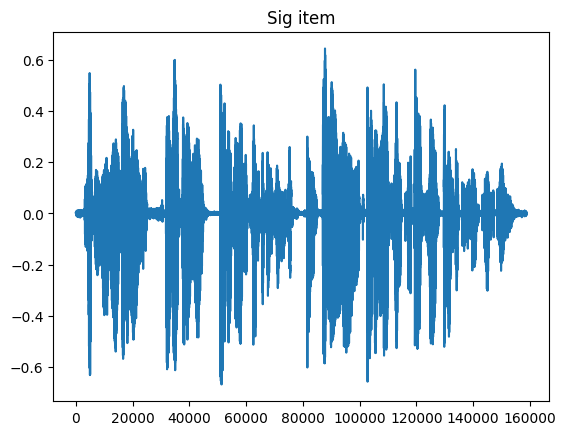

In [84]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("Sig item")
plt.plot(dataset[0]["signal"])
plt.show()

It can be seen that the `DynamicItemDataset` object returns the two specified items from the JSON annotation.

The `file_path` item, is taken directly, as it is, from the JSON annotation without further processing.
The other one is instead a new item derived from `file_path` item with the pipeline we have defined before.

There is no constraints in what can be done in the pipelines: as said the user can also use their own functions:

In [85]:
import soundfile as sf
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("sig_numpy")
def audio_pipeline_numpy(file_path):
      sig, _ = sf.read(file_path, dtype="float32")
      return sig

In [86]:
speechbrain.dataio.dataset.add_dynamic_item([dataset], audio_pipeline_numpy)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["signal", "file_path", "sig_numpy"],
    )
dataset[0]

{'signal': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'file_path': 'LibriSpeech/dev-clean-2/3576/138058/3576-138058-0019.flac',
 'sig_numpy': array([ 0.00201416,  0.00061035,  0.00036621, ..., -0.00332642,
        -0.00335693, -0.00292969], dtype=float32)}

The dataset object now also returns the signal as read with the soundfile library instead of only the one with read with the built-in speechbrain function which is based on torchaudio.

**Multiple outputs can be specified by one pipeline by using python generators syntax**.

In the example below three outputs are specified, the last two depend directly from the first one (sig) and are transformed version of this latter: with a random gain factor `rand_gain_sig` and with a constant offset `offset_sig`.

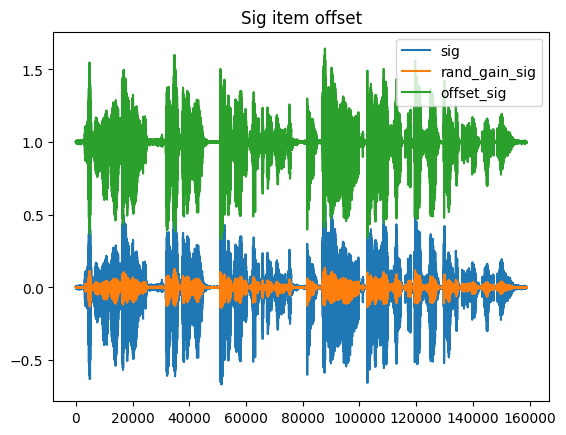

In [87]:
import random
@speechbrain.utils.data_pipeline.takes("file_path")
@speechbrain.utils.data_pipeline.provides("sig", "rand_gain_sig", "offset_sig")
def audio_pipeline(file_path):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      yield sig
      rand_gain_sig = random.random()*sig
      yield rand_gain_sig
      offset_sig = sig + 1
      yield offset_sig


speechbrain.dataio.dataset.add_dynamic_item([dataset], audio_pipeline)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig", "rand_gain_sig", "offset_sig"],
    )

plt.figure(1)
plt.title("Sig item")
plt.plot(dataset[0]["sig"])

plt.title("Sig item with random gain")
plt.plot(dataset[0]["rand_gain_sig"])

plt.title("Sig item offset")
plt.plot(dataset[0]["offset_sig"])
plt.legend(["sig", "rand_gain_sig", "offset_sig"])
plt.show()

This toy example demonstrates that multiple items can be fetched from the same pipeline and dynamically created items can depend on other dynamically created items (`offset_sig` depends on `sig`).

But dynamic items can also depend on dynamically created items from another, pre-specified pipeline:


In [88]:
@speechbrain.utils.data_pipeline.takes("sig")
@speechbrain.utils.data_pipeline.provides("sig_as_python_list")
def to_list_pipeline(sig):
      yield sig.numpy().tolist()


speechbrain.dataio.dataset.add_dynamic_item([dataset], to_list_pipeline)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig_as_python_list"],
    )
dataset[0]["sig_as_python_list"][:10]

[0.00201416015625,
 0.0006103515625,
 0.0003662109375,
 0.001129150390625,
 0.000946044921875,
 0.0001220703125,
 -0.000732421875,
 0.00164794921875,
 0.002685546875,
 0.000457763671875]

In this example we have defined a new pipeline which takes `sig` and turns it from `torch.tensor` to a python list obtaining a new dynamic item `sig_as_python_list`.


**NOTE**


Since we are requesting in the output only `sig_as_python_list` which depends itself from `sig`, dynamic items `offset_sig` and `rand_gain_sig` are not computed at all. Only `sig` is computed implicitly as it is necessary to obtain `sig_as_python_list`.


In fact under the hood `DynamicItemDataset` finds a suitable evaluation
order for the requested items by constructing a **computational graph** defined by the **pipelines**.

**An error is returned if any circular dependency is present between the pipelines**.


A **DIP** can also take multiple items/annotation keys in input, the syntax is the same as for the output items:

In [89]:
@speechbrain.utils.data_pipeline.takes("file_path", "spkID")
@speechbrain.utils.data_pipeline.provides("sig", "spkidstring")
def multiple_dip(file_path, spkID):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      yield sig
      yield spkID

speechbrain.dataio.dataset.add_dynamic_item([dataset], multiple_dip)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig", "spkidstring"],
    )
dataset[0]

{'sig': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'spkidstring': 3576}

In [90]:
@speechbrain.utils.data_pipeline.takes("file_path", "spkID")
@speechbrain.utils.data_pipeline.provides("sig_tuple")
def multiple_dip(file_path, spkID):
      sig = speechbrain.dataio.dataio.read_audio(file_path)
      yield sig, spkID


speechbrain.dataio.dataset.add_dynamic_item([dataset], multiple_dip)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["sig_tuple"],
    )
dataset[0] # sig now is a tuple

{'sig_tuple': (tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
  3576)}

And also the same **DIP** can be used in multiple datasets.
E.g. you want usually the read audio **DIP** to be the same for validation, training and test:

In [91]:
validation = DynamicItemDataset.from_json("data.json")
train = DynamicItemDataset.from_json("data.json")

speechbrain.dataio.dataset.add_dynamic_item([validation, train], speechbrain.dataio.dataio.read_audio, takes="file_path", provides="signal")
speechbrain.dataio.dataset.set_output_keys([validation, train], ["id", "signal", "words"])
validation[0]


{'id': '3576-138058-0019',
 'signal': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'words': 'GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE I WILL GO IN QUEST OF THIS KNIGHT AND DEAD OR ALIVE I WILL MAKE HIM KEEP HIS WORD PLIGHTED TO SO GREAT BEAUTY'}

In [92]:
train[0]

{'id': '3576-138058-0019',
 'signal': tensor([ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029]),
 'words': 'GIVE ME MY HORSE AND ARMS AND WAIT FOR ME HERE I WILL GO IN QUEST OF THIS KNIGHT AND DEAD OR ALIVE I WILL MAKE HIM KEEP HIS WORD PLIGHTED TO SO GREAT BEAUTY'}

#### Cached pipeline
One last thing you can do with pipelines is to cache the result if the computation is expensive and static. For example, if you are using frozen deep embeddings, these may be a good candidate for caching. Here, we simply cache the feature extraction, although it doesn't add much time to the overall pipeline.

In [93]:
filterbank = speechbrain.lobes.features.Fbank()

# Must take "id" for storing and retrieving from the cache
@speechbrain.utils.data_pipeline.CachedDynamicItem.cache("feature_cache")
@speechbrain.utils.data_pipeline.takes("id", "sig")
@speechbrain.utils.data_pipeline.provides("feats")
def feature_pipeline(uid, sig):
    # Fake batch dimension -- data items are singular
    return filterbank(sig.unsqueeze(0)).squeeze(0)

speechbrain.dataio.dataset.add_dynamic_item([dataset], feature_pipeline)
speechbrain.dataio.dataset.set_output_keys([dataset], ["id", "feats"])
print(dataset[0]["id"], dataset[0]["feats"].shape)
print(dataset[1]["id"], dataset[1]["feats"].shape)

3576-138058-0019 torch.Size([994, 40])
3576-138058-0021 torch.Size([619, 40])


The results of the dynamic items are stored in torch format, one file per uid:

In [94]:
import os
print(os.listdir("feature_cache"))
test_id = dataset[0]["id"]
print("Size of", test_id, torch.load(f"feature_cache/{test_id}.pt").shape)

['5694-64038-0005.pt', '1988-24833-0004.pt', '6295-244435-0018.pt', '5895-34622-0014.pt', '3576-138058-0001.pt', '1988-24833-0025.pt', '5895-34629-0025.pt', '2803-154320-0005.pt', '5338-284437-0006.pt', '1462-170145-0019.pt', '6295-244435-0040.pt', '7850-281318-0007.pt', '5338-284437-0025.pt', '2803-161169-0005.pt', '5895-34629-0001.pt', '5895-34615-0014.pt', '777-126732-0019.pt', '8297-275156-0010.pt', '251-136532-0003.pt', '2412-153948-0013.pt', '5895-34622-0022.pt', '1462-170145-0016.pt', '1272-135031-0019.pt', '2803-154320-0013.pt', '5338-284437-0009.pt', '6319-57405-0012.pt', '8842-304647-0002.pt', '3752-4944-0054.pt', '3536-23268-0008.pt', '6241-61946-0019.pt', '7976-110523-0013.pt', '2803-154320-0000.pt', '7976-110523-0006.pt', '3752-4944-0011.pt', '3752-4944-0038.pt', '5338-284437-0004.pt', '777-126732-0057.pt', '3536-23268-0000.pt', '1462-170142-0028.pt', '3752-4944-0039.pt', '1988-147956-0007.pt', '1988-24833-0028.pt', '251-118436-0018.pt', '2428-83699-0028.pt', '3576-138058-

You can warm the cache by just loading every item. We provide a convenience function for this:

In [95]:
dataset.iterate_once()

100%|██████████| 1089/1089 [00:09<00:00, 118.08it/s]


In [96]:
print("Number of files in the cache folder:", len(os.listdir("feature_cache")))

Number of files in the cache folder: 1089


#### HDF5 cached pipelines (single-file cache)

`CachedHDF5DynamicItem` keeps every cached output in a single HDF5 file instead of one `.pt` file per example. This reduces filesystem overhead and is easier to share across multi-worker dataloaders. The first argument still needs to be the example `id`, and optional compression is supported.


In [97]:
import os, shutil
from speechbrain.integrations.hdf5.cached_item import CachedHDF5DynamicItem

shutil.rmtree("hdf5_feature_cache", ignore_errors=True)
os.makedirs("hdf5_feature_cache", exist_ok=True)

hdf5_filterbank = speechbrain.lobes.features.Fbank()

@CachedHDF5DynamicItem.cache(
    "hdf5_feature_cache",
    compression="gzip",
    cache_filename="features.hdf5",
)
@speechbrain.utils.data_pipeline.takes("id", "sig")
@speechbrain.utils.data_pipeline.provides("hdf5_feats")
def hdf5_feature_pipeline(uid, sig):
    # Deterministic features are great candidates for caching.
    return hdf5_filterbank(sig.unsqueeze(0)).squeeze(0)

speechbrain.dataio.dataset.add_dynamic_item([dataset], hdf5_feature_pipeline)
speechbrain.dataio.dataset.set_output_keys([dataset], ["id", "hdf5_feats"])

first = dataset[0]
first["id"], first["hdf5_feats"].shape


('3576-138058-0019', torch.Size([994, 40]))

The cache now lives in a single file instead of many small ones:


In [98]:
hdf5_path = hdf5_feature_pipeline.hdf5_path
print("Cache file:", hdf5_path)
print("Datasets inside cache (truncated):", list(hdf5_feature_pipeline.hdf5file.keys())[:3])
print("Compression:", hdf5_feature_pipeline.hdf5file[first["id"]].compression)


Cache file: hdf5_feature_cache/features.hdf5
Datasets inside cache (truncated): ['3576-138058-0019']
Compression: gzip


You can warm the cache once, then reopen it read-only when using multiple DataLoader workers to avoid write contention:


In [99]:
dataset.iterate_once(output_keys=["id", "hdf5_feats"], progressbar=False)
hdf5_feature_pipeline.change_file_mode("r")
print("HDF5 mode after switching:", hdf5_feature_pipeline.hdf5file.mode)
print("Number of cached items:", len(hdf5_feature_pipeline.hdf5file.keys()))


HDF5 mode after switching: r
Number of cached items: 1089


### CategoricalEncoder

SpeechBrain `dataio` provides a `CategoricalEncoder` class for encoding labels which belongs to a discrete set: e.g. for speaker recognition or any other multi-class classification problem.

Given a collection of hashables (e.g. strings) it encodes
    every unique item to an integer value: `["spk0", "spk1"]` --> `[0, 1]`


  Internally the correspondence between each label to its index is handled by
  two dictionaries: `lab2ind` and `ind2lab`.

It is built to tightly integrate with `DynamicItemDataset` and `dataIO pipelines`.

For example one can obtain the encoding for speaker identities (`spkID` in JSON) from our Mini-LibriSpeech dataset by creating an instance of CategoricalEncoder and fitting it to the dataset object.

In [100]:
from speechbrain.dataio.encoder import CategoricalEncoder
spk_id_encoder = CategoricalEncoder()

Since `DynamicItemDataset` right now does not return spkID we have firstly to set its output to return that dynamic item:

In [101]:
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["spkID"],
    )
# sig is a torch.tensor with audio signal as specified before.
# REMEMBER: no need to specify the pipeline for spkID as we can read directly the value from the JSON.
dataset[0]

{'spkID': 3576}

The speaker identity `spkID` is a string.

Note that in librispeech it is a string containing a unique integer so one can argue that performing the encoding here is pointless as casting to integer will suffice.

However, it could happen that it is not an unique integer but an unique string like `spk1`, `spk2` et cetera.

`spk_id_encoder` can be used for this purpose. We fit the encoder to the dataset and specify which *dynamic item* we want to encode:

In [102]:
spk_id_encoder.update_from_didataset(dataset, "spkID")

**NOTE**


This will iterate over dataset fetch for each example spkID and construct
internal dicts lab2ind and ind2lab.

Because of this, it is important to call `dataset.set_output_keys` avoiding
computationally costly dynamic items (e.g. can happen if the pipeline does data augmentation) before fitting the encoder.

Setting only the key on which the encoder will be fitted is a good approach.

We can look now at how much unique speaker ids there are in the dataset by using `__len__`

In [103]:
len(spk_id_encoder)

26

We can also take a look to the encoder internal dictionaries `lab2ind` ans `ind2lab` which contains the mappings between the labels (speaker ids in this case)  and corresponding integers encodings:

In [104]:
spk_id_encoder.lab2ind
# contains label --> integer encoding

{3576: 0,
 174: 1,
 6295: 2,
 3752: 3,
 1988: 4,
 5694: 5,
 1462: 6,
 1272: 7,
 2428: 8,
 7976: 9,
 2412: 10,
 5895: 11,
 251: 12,
 2803: 13,
 8842: 14,
 5338: 15,
 6241: 16,
 3000: 17,
 6319: 18,
 84: 19,
 777: 20,
 7850: 21,
 8297: 22,
 1993: 23,
 2035: 24,
 3536: 25}

In [105]:
spk_id_encoder.ind2lab # contains integer encoding --> label

{0: 3576,
 1: 174,
 2: 6295,
 3: 3752,
 4: 1988,
 5: 5694,
 6: 1462,
 7: 1272,
 8: 2428,
 9: 7976,
 10: 2412,
 11: 5895,
 12: 251,
 13: 2803,
 14: 8842,
 15: 5338,
 16: 6241,
 17: 3000,
 18: 6319,
 19: 84,
 20: 777,
 21: 7850,
 22: 8297,
 23: 1993,
 24: 2035,
 25: 3536}

Once fitted the `CategoricalEncoder` object can be used in a suitably defined pipeline to encode the spkID key and return the encoded value:

In [106]:
@speechbrain.utils.data_pipeline.takes("spkID")
@speechbrain.utils.data_pipeline.provides("spkid_encoded")
def spk_id_encoding(spkid):
      return torch.LongTensor([spk_id_encoder.encode_label(spkid)])


In [107]:
speechbrain.dataio.dataset.add_dynamic_item([dataset], spk_id_encoding)
speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["spkid_encoded"],
    )

dataset[100]

{'spkid_encoded': tensor([2])}

### PaddedBatch and SaveableDataLoader

SpeechBrain offers a way to conveniently pad right automatically tensors of different length on multiple dimensions.
This is achieved using the `PaddedBatch` class defined in `speechbrain.dataio.batch`.

`PaddedBatch` is both a `collate_fn` and a batch object.

When a `torch.utils.data.Dataset` (and thus also a `DynamicItemDataset`) is passed to the `Brain` class `PaddedBatch` is used as the default collate function `collate_fn` and examples are automatically padded together.

As the default DataLoader the Brain class instantiates, a SpeechBrain custom DataLoader: `speechbrain.dataio.dataloader.SaveableDataLoader`.


This DataLoader is identical to the plain one except that it allows for intra-epoch saving. So if for some reason training stops in the middle of an epoch it is possible to resume from exactly that step. See the [Checkpointing Tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/checkpointing.html).
The default `collate_fn` for this DataLoader is `PaddedBatch`.


In [108]:
from speechbrain.dataio.dataloader import SaveableDataLoader
from speechbrain.dataio.batch import PaddedBatch

speechbrain.dataio.dataset.set_output_keys(
        [dataset], ["id", "spkid_encoded", "signal"],
    )

We set as the dynamic items we are requesting `sig` which is the audio tensor
and the speaker id encoded with the `CategoricalEncoder` object (`spkid_encoded`) defined before and the example `id`.

In [109]:
dataloader = SaveableDataLoader(dataset, batch_size=2, collate_fn=PaddedBatch)

In [110]:
batch_obj = next(iter(dataloader)) # let's look at the batch obj

In [111]:
batch_obj # the dataloader returns an PaddedBatch obj now
type(batch_obj)

speechbrain.dataio.batch.PaddedBatch

Dynamic Items can be accessed in the batch object by using `dict` syntax:

In [112]:
batch_obj["spkid_encoded"]

PaddedData(data=tensor([[0],
        [0]]), lengths=tensor([1., 1.]))

In [113]:
batch_obj["signal"]

PaddedData(data=tensor([[ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029],
        [-0.0018, -0.0023, -0.0027,  ...,  0.0000,  0.0000,  0.0000]]), lengths=tensor([1.0000, 0.6220]))

In [114]:
batch_obj["id"] # example ids in this batch useful for debugging

['3576-138058-0019', '3576-138058-0021']

As said, all elements in PaddedBatch which are `torch.Tensors` are padded together by adding zeros to the right.
When these elements are accessed a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) is returned: the actual padded tensors and a `length` tensor.

In [115]:
wav_data, length = batch_obj["signal"]

As it is a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) the two items *length* and *data* are also accessible as attributes:

In [116]:
lengths = batch_obj["signal"].lengths
wav_data = batch_obj["signal"].data

In [117]:
lengths

tensor([1.0000, 0.6220])

This length tensor contains the relative true length of each sequence.
In this example it means that the second example in the batch has not been padded (relative length == 1) while the first instead has been padded to more twice its length.

The use of relative lengths instead of absolute indexes guarantees that that these values do not change even after feature extraction: the relative true length remains the same even after STFT whatever is the window.

The absolute indexes are easy to obtain:

In [118]:
abs_lens = (lengths*wav_data.shape[1]).long()
abs_lens

tensor([158960,  98879])

In [119]:
wav_data[1][:abs_lens[1]] # no zeros

tensor([-0.0018, -0.0023, -0.0027,  ...,  0.0042,  0.0052,  0.0038])

In [120]:
wav_data[1][abs_lens[1]:] # zeros begins at abs_lens[0]

tensor([0.0019, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])

The PaddedBatch object allows for conveniently moving all dynamic items which are` torch.Tensor` to the right device using to:

In [121]:
batch_obj = batch_obj.to("cpu")

Of course items which are not tensors such as `id` are not moved and are not padded. Instead they are simply returned as a list.

In [122]:
batch_obj["id"]

['3576-138058-0019', '3576-138058-0021']

It is also possible to iterate over the examples of `PaddedBatch`:

In [123]:
for ex in batch_obj:
  print(ex)

['3576-138058-0019', '3576-138058-0021']
PaddedData(data=tensor([[0],
        [0]]), lengths=tensor([1., 1.]))
PaddedData(data=tensor([[ 0.0020,  0.0006,  0.0004,  ..., -0.0033, -0.0034, -0.0029],
        [-0.0018, -0.0023, -0.0027,  ...,  0.0000,  0.0000,  0.0000]]), lengths=tensor([1.0000, 0.6220]))


And access a single example by its position:

In [124]:
batch_obj.at_position(1)

PaddedData(data=tensor([[0],
        [0]]), lengths=tensor([1., 1.]))

These methods can be conveniently used in the `Brain` class `compute_forward` and `compute_objectives` methods.
As we have shown in the first example of this tutorial where a complete dataIO example was illustrated:




```python
def compute_forward(self, batch, stage):
    audio, audio_len = batch["sig"]
    # the examples are automatically padded, audio_len contains the relative
    # length of the original sequence.
    return self.modules.model(audio.unsqueeze(1)).mean(-1).unsqueeze(-1)
    
  def compute_objectives(self, logits, batch, stage):
    spk_ids, _ = batch["spkid_encoded"]
    return torch.nn.functional.cross_entropy(logits, spk_ids)
```



## Full Example: Training a simple Speaker Recognition System.

Hereafter we show how the **DynamicItemDataset**, **DIPs** and **CategoricalEncoder** can be used to build a data pipeline for Speaker Recognition.

In particular we have to:

- read the audio
- read the speaker ID from annotation and encode it to integer


We firstly instantiate the dataset from that JSON annotation

In [125]:
dataset = DynamicItemDataset.from_json("data.json")

Then fit the **CategoricalEncoder** to speaker IDs (`spkID`) in the annotation.

In [126]:
spk_id_encoder = CategoricalEncoder()
spk_id_encoder.update_from_didataset(dataset, "spkID")

We add the **DIP** which encodes `spkID`

In [127]:
dataset.add_dynamic_item(spk_id_encoder.encode_label_torch, takes="spkID", provides="spk_encoded")


We add the **DIP** for reading the audio


In [128]:
dataset.add_dynamic_item(speechbrain.dataio.dataio.read_audio, takes="file_path", provides="signal")


#### Caching features for the speaker pipeline

We can cache the filterbank features so each epoch only reads them from a single HDF5 file instead of recomputing them or creating thousands of small `.pt` files. This mirrors the caching workflow shown earlier, but plugs directly into the speaker-recognition `DynamicItemDataset`.


In [129]:
import os, shutil
from speechbrain.integrations.hdf5.cached_item import CachedHDF5DynamicItem
from speechbrain.lobes.features import Fbank

# Clean cache for a reproducible run in the notebook
shutil.rmtree("spk_feat_cache", ignore_errors=True)
os.makedirs("spk_feat_cache", exist_ok=True)

fbank = Fbank()

@CachedHDF5DynamicItem.cache(
    cache_location="spk_feat_cache",
    cache_filename="speaker_feats.hdf5",
    compression="gzip",
)
@speechbrain.utils.data_pipeline.takes("id", "signal")
@speechbrain.utils.data_pipeline.provides("feats")
def cached_fbank(uid, sig):
    return fbank(sig.unsqueeze(0)).squeeze(0)

dataset.add_dynamic_item(cached_fbank)


The cache is lazy: the first access to an utterance writes it into `speaker_feats.hdf5`. Reusing the notebook (or multiple workers) just reads from the same file.


and set the outputs of the dataset we want to access in training loop

In [130]:
dataset.set_output_keys(["id", "feats", "spk_encoded"])


We sort the dataset based on length to speed up training so that we minimize in batches the amount of padded elements.

In [131]:
sorted_data = dataset.filtered_sorted(sort_key="length")

We can train now a simple classifier, by passing the dataset object directly to the **Brain** class. The **Brain** class will automatically create a SaveableDataLoader with specified `train_loader_kwargs` and will be handling the padding for you.

In [132]:
from speechbrain.lobes.features import MFCC, Fbank
from speechbrain.nnet.losses import nll_loss


class SimpleBrain(speechbrain.Brain):
    def compute_forward(self, batch, stage):
        x = batch.feats.data
        x = self.modules.encoder(x)
        x = self.modules.pooling(x, batch.feats.lengths)
        x = self.modules.to_output(x)
        return self.modules.softmax(x)

    def compute_objectives(self, logits, batch, stage):
        return nll_loss(logits, batch.spk_encoded.data)

modules = {
    "encoder": torch.nn.Sequential(torch.nn.Linear(40, 256),
                                   torch.nn.ReLU()),
    "pooling": speechbrain.nnet.pooling.StatisticsPooling(),
    "to_output": torch.nn.Linear(512, len(spk_id_encoder)),
    "softmax": speechbrain.nnet.activations.Softmax(apply_log=True)
}
brain = SimpleBrain(modules, opt_class=lambda x: torch.optim.SGD(x, 0.01), run_opts={"device": "cpu"})
brain.fit(range(1), train_set=sorted_data,
          train_loader_kwargs={"batch_size": 16, "drop_last":True})


INFO:speechbrain.core:Gradscaler enabled: `False`
INFO:speechbrain.core:Using training precision: `--precision=fp32`
INFO:speechbrain.core:Using evaluation precision: `--eval_precision=fp32`
INFO:speechbrain.core:SimpleBrain Model Statistics:
* Total Number of Trainable Parameters: 23.8k
* Total Number of Parameters: 23.8k
* Trainable Parameters represent 100.0000% of the total size.
100%|██████████| 68/68 [00:25<00:00,  2.70it/s, train_loss=4.22]


## Authors

- SpeechBrain team: Mirco Ravanelli, Titouan Parcollet, Peter Plantinga, and Adel Moumen (2026)

## Acknowledgements



*   Many thanks to Nasser Benabderrazik ([lenassero](https://github.com/lenassero)) who helped improving this Tutorial.





## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```